In [1]:
from sql_graph_translate.seq_to_graph import parse
from sql_graph_translate.nodes import create_nodes
from sql_graph_translate.metrics import target_values_map, flexible_denotation_accuracy, to_value_list

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/conda/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


<ipykernel.iostream.OutStream object at 0x7f1ee9d8c460> Reading dataset from /home/jovyan/cloud/postgraduate/works/Partial-Exec/data/tables/tagged/pristine-seen-tables.tagged
<ipykernel.iostream.OutStream object at 0x7f1ee9d8c460> Reading dataset from /home/jovyan/cloud/postgraduate/works/Partial-Exec/data/tables/tagged/pristine-unseen-tables.tagged
<ipykernel.iostream.OutStream object at 0x7f1ee9d8c460> Reading dataset from /home/jovyan/cloud/postgraduate/works/Partial-Exec/data/tables/tagged/training.tagged


In [2]:
from datasets import load_dataset,load_from_disk

In [3]:
data = load_dataset('text', data_files={
                           'train': ['tapex_pretrain/train.src', 'tapex_pretrain/train.tgt']
                       },

                       split='train')

In [4]:
train_tgt = data['text'][int(data.num_rows/2):]
train_src = data['text'][:int(data.num_rows/2)]

In [39]:
train_src[7]

"select year opened where termini = 'west portal station' col : line | year opened | termini | termini row 1 : j church | 1917 | embarcadero station | balboa park station row 2 : k ingleside | 1918 | embarcadero station | balboa park station row 3 : l taraval | 1919 | embarcadero station | 46th avenue and wawona san francisco zoo row 4 : m ocean view | 1925 | embarcadero station | san jose and geneva balboa park station row 5 : n judah | 1928 | 4th and king station caltrain depot | judah and la playa ocean beach row 6 : t third street | 2007 | west portal station | sunnydale station row 7 : s castro shuttle (peak hours & game days) | none | embarcadero station 4th and king station (game days) | castro station west portal station (game days)"

In [40]:
train_tgt[7]

'2007'

# linear Table Desearilization

In [5]:
import json

In [6]:
import re
import pandas as pd
def deserializ_tapex_linear_table(linear_table):
    
    head_pattern = r" col :(.*) row 1 : "
    row_pattern = r" row \d+ : "
    coll_delimetr = " | "
    heads = [h.strip() for h in 
             re.search(head_pattern,linear_table)[0].replace(" col : ","",1).replace(" row 1 : ","",1).split(coll_delimetr)]
    rows = [[r.strip() for r in row.split(coll_delimetr)] for row in re.split(row_pattern,linear_table)[1:]]
    return pd.DataFrame(rows,columns=heads)

In [7]:
def serialize_table_to_tapex_format(df):
    head_pattern = " col : "
    row_pattern = " row {num} : "
    coll_delimetr = " | "
    
    lin_table = head_pattern+coll_delimetr.join(df.columns)
    for i,row in df.iterrows():
        print(row_pattern.format(num=i+1))
        lin_table+=row_pattern.format(num=i+1)+coll_delimetr.join(str(r) for r in row.values)
    
    return lin_table

In [8]:
pattern = ' col : '
try:
    sql,_ = train_src[28050].split(pattern)
    print(sql)
except Exception as e:
    print(e)
sql  = sql.strip()
lin_table = " col : "+train_src[28050].split(" col : ")[1]
df = deserializ_tapex_linear_table(lin_table)

select post season result order by regular season win % desc limit 1


In [9]:
lin_table

' col : team | year | regular season won | regular season lost | regular season ties | regular season win % | regular season finish | post season won | post season lost | post season win % | post season result row 1 : den | 1981 | 10 | 6 | 0 | 0.625 | 2nd in afc west | none | none | none | none row 2 : den | 1982 | 2 | 7 | 0 | 0.222 | 5th in afc west | none | none | none | none row 3 : den | 1983 | 9 | 7 | 0 | 0.563 | 2nd in afc west | 0 | 1 | 0 | lost to seattle seahawks in afc wild card game row 4 : den | 1984 | 13 | 3 | 0 | 0.813 | 1st in afc west | 0 | 1 | 0 | lost to pittsburgh steelers in afc divisional game row 5 : den | 1985 | 11 | 5 | 0 | 0.688 | 2nd in afc west | none | none | none | none row 6 : den | 1986 | 11 | 5 | 0 | 0.688 | 1st in afc west | 2 | 1 | 0.667 | lost to new york giants in super bowl xxi row 7 : den | 1987 | 10 | 4 | 1 | 0.714 | 1st in afc west | 2 | 1 | 0.667 | lost to washington redskins in super bowl xxii row 8 : den | 1988 | 8 | 8 | 0 | 0.5 | 2nd in afc w

### Correcting sql query

In [10]:
new_column_names = []
for head in df.columns:
    if len(head.split(" "))>1:
        head_new = "_".join(head.split(' '))
        sql = re.sub(head,f'"{head_new}"',sql)
        new_column_names.append(f'"{head_new}"')
    else:
        new_column_names.append(head)
df.columns = new_column_names

In [11]:
new_column_names

['team',
 'year',
 '"regular_season_won"',
 '"regular_season_lost"',
 '"regular_season_ties"',
 '"regular_season_win_%"',
 '"regular_season_finish"',
 '"post_season_won"',
 '"post_season_lost"',
 '"post_season_win_%"',
 '"post_season_result"']

In [12]:
df

,team,year,"""regular_season_won""","""regular_season_lost""","""regular_season_ties""","""regular_season_win_%""","""regular_season_finish""","""post_season_won""","""post_season_lost""","""post_season_win_%""","""post_season_result"""
0,den,1981,10,6,0,0.625,2nd in afc west,none,none,none,none
1,den,1982,2,7,0,0.222,5th in afc west,none,none,none,none
2,den,1983,9,7,0,0.563,2nd in afc west,0,1,0,lost to seattle seahawks in afc wild card game
3,den,1984,13,3,0,0.813,1st in afc west,0,1,0,lost to pittsburgh steelers in afc divisional ...
4,den,1985,11,5,0,0.688,2nd in afc west,none,none,none,none
5,den,1986,11,5,0,0.688,1st in afc west,2,1,0.667,lost to new york giants in super bowl xxi
6,den,1987,10,4,1,0.714,1st in afc west,2,1,0.667,lost to washington redskins in super bowl xxii
7,den,1988,8,8,0,0.5,2nd in afc west,none,none,none,none
8,den,1989,11,5,0,0.688,1st in afc west,2,1,0.667,lost to san francisco 49ers in super bowl xxiv
9,den,1990,5,11,0,0.313,5th in afc west,none,none,none,none


In [13]:
sql

'select "post_season_result" order by "regular_season_win_%" desc limit 1'

# Modify Table for PartExec scrypts

In [14]:
import numpy as np

In [15]:
df['agg'] = np.zeros(df.shape[0])

In [16]:
df

,team,year,"""regular_season_won""","""regular_season_lost""","""regular_season_ties""","""regular_season_win_%""","""regular_season_finish""","""post_season_won""","""post_season_lost""","""post_season_win_%""","""post_season_result""",agg
0,den,1981,10,6,0,0.625,2nd in afc west,none,none,none,none,0.0
1,den,1982,2,7,0,0.222,5th in afc west,none,none,none,none,0.0
2,den,1983,9,7,0,0.563,2nd in afc west,0,1,0,lost to seattle seahawks in afc wild card game,0.0
3,den,1984,13,3,0,0.813,1st in afc west,0,1,0,lost to pittsburgh steelers in afc divisional ...,0.0
4,den,1985,11,5,0,0.688,2nd in afc west,none,none,none,none,0.0
5,den,1986,11,5,0,0.688,1st in afc west,2,1,0.667,lost to new york giants in super bowl xxi,0.0
6,den,1987,10,4,1,0.714,1st in afc west,2,1,0.667,lost to washington redskins in super bowl xxii,0.0
7,den,1988,8,8,0,0.5,2nd in afc west,none,none,none,none,0.0
8,den,1989,11,5,0,0.688,1st in afc west,2,1,0.667,lost to san francisco 49ers in super bowl xxiv,0.0
9,den,1990,5,11,0,0.313,5th in afc west,none,none,none,none,0.0


# translate SQL to GRAPH


In [17]:
lin_table2 = serialize_table_to_tapex_format(df)

 row 1 : 
 row 2 : 
 row 3 : 
 row 4 : 
 row 5 : 
 row 6 : 
 row 7 : 
 row 8 : 
 row 9 : 
 row 10 : 
 row 11 : 
 row 12 : 
 row 13 : 
 row 14 : 
 row 15 : 
 row 16 : 
 row 17 : 
 row 18 : 
 row 19 : 
 row 20 : 
 row 21 : 
 row 22 : 
 row 23 : 
 row 24 : 
 row 25 : 
 row 26 : 
 row 27 : 


In [18]:
lin_table

' col : team | year | regular season won | regular season lost | regular season ties | regular season win % | regular season finish | post season won | post season lost | post season win % | post season result row 1 : den | 1981 | 10 | 6 | 0 | 0.625 | 2nd in afc west | none | none | none | none row 2 : den | 1982 | 2 | 7 | 0 | 0.222 | 5th in afc west | none | none | none | none row 3 : den | 1983 | 9 | 7 | 0 | 0.563 | 2nd in afc west | 0 | 1 | 0 | lost to seattle seahawks in afc wild card game row 4 : den | 1984 | 13 | 3 | 0 | 0.813 | 1st in afc west | 0 | 1 | 0 | lost to pittsburgh steelers in afc divisional game row 5 : den | 1985 | 11 | 5 | 0 | 0.688 | 2nd in afc west | none | none | none | none row 6 : den | 1986 | 11 | 5 | 0 | 0.688 | 1st in afc west | 2 | 1 | 0.667 | lost to new york giants in super bowl xxi row 7 : den | 1987 | 10 | 4 | 1 | 0.714 | 1st in afc west | 2 | 1 | 0.667 | lost to washington redskins in super bowl xxii row 8 : den | 1988 | 8 | 8 | 0 | 0.5 | 2nd in afc w

In [19]:
lin_table2

' col : team | year | "regular_season_won" | "regular_season_lost" | "regular_season_ties" | "regular_season_win_%" | "regular_season_finish" | "post_season_won" | "post_season_lost" | "post_season_win_%" | "post_season_result" | agg row 1 : den | 1981 | 10 | 6 | 0 | 0.625 | 2nd in afc west | none | none | none | none | 0.0 row 2 : den | 1982 | 2 | 7 | 0 | 0.222 | 5th in afc west | none | none | none | none | 0.0 row 3 : den | 1983 | 9 | 7 | 0 | 0.563 | 2nd in afc west | 0 | 1 | 0 | lost to seattle seahawks in afc wild card game | 0.0 row 4 : den | 1984 | 13 | 3 | 0 | 0.813 | 1st in afc west | 0 | 1 | 0 | lost to pittsburgh steelers in afc divisional game | 0.0 row 5 : den | 1985 | 11 | 5 | 0 | 0.688 | 2nd in afc west | none | none | none | none | 0.0 row 6 : den | 1986 | 11 | 5 | 0 | 0.688 | 1st in afc west | 2 | 1 | 0.667 | lost to new york giants in super bowl xxi | 0.0 row 7 : den | 1987 | 10 | 4 | 1 | 0.714 | 1st in afc west | 2 | 1 | 0.667 | lost to washington redskins in super b

In [20]:
import importlib
import sql_graph_translate.nodes

In [21]:
import importlib

import sys

from sql_graph_translate import nodes  # Пусть новый модуль


# Перезагрузка модуля

importlib.reload(nodes)


# Удаляем старую ссылку на функцию

if 'create_nodes' in sys.modules:

    del sys.modules['sql_graph_translate.nodes.create_nodes']


In [22]:
importlib.reload(sql_graph_translate.nodes)

<module 'sql_graph_translate.nodes' from '/home/jovyan/cloud/postgraduate/works/OmniGraph/TapexGraph/sql_graph_translate/nodes.py'>

In [24]:
from sql_graph_translate import nodes

In [26]:
sql

'select "post_season_result" order by "regular_season_win_%" desc limit 1'

In [12]:
flatten_mode = 'preorder'

G0 = create_nodes(sql, df=df)
header = G0.header
result0 = to_value_list(G0.executed_last_node())
flatten_sequence = G0.linearize_graph(Omega_include, flatten_mode=traversal)
G1 = parse(flatten_sequence, header, flatten_mode=traversal)


logging.info("Flatten sequence: %s", flatten_sequence)
result1 = to_value_list(G1.executed_last_node())

In [13]:
u=[]
d={}

In [14]:
create_nodes?

In [26]:
G0 = nodes.create_nodes(sql, df=df,edges=u, condi_expressions=d)

[]
[(SELECT expressions: 
  (COLUMN this: 
    (IDENTIFIER this: post_season_result, quoted: True)), limit: 
  (LIMIT expression: 
    (LITERAL this: 1, is_string: False)), order: 
  (ORDER expressions: 
    (ORDERED this: 
      (COLUMN this: 
        (IDENTIFIER this: regular_season_win_%, quoted: True)), desc: True, nulls_first: False)))]
sub-query SELECT "post_season_result" ORDER BY "regular_season_win_%" DESC LIMIT 1 type <class 'sqlglot.expressions.Select'>
edges,cond
[('N22|P|select|0|0|"post_season_result"', 'N14|OB|order|0|0|desc'), ('N14|OB|order|0|0|desc', 'N6|L|limit|0|0|limit 1'), ('N17|P|order|0|0|"regular_season_win_%"', 'N14|OB|order|0|0|desc')] {'P|select|0|0|"post_season_result"': (COLUMN this: 
  (IDENTIFIER this: post_season_result, quoted: True)), 'L|limit|0|0|limit 1': (LIMIT expression: 
  (LITERAL this: 1, is_string: False)), 'OB|order|0|0|desc': 'desc', 'P|order|0|0|"regular_season_win_%"': (COLUMN this: 
  (IDENTIFIER this: regular_season_win_%, quoted: True)

In [39]:
u

[('N22|P|select|0|0|"post_season_result"', 'N14|OB|order|0|0|desc'),
 ('N14|OB|order|0|0|desc', 'N6|L|limit|0|0|limit 1'),
 ('N17|P|order|0|0|"regular_season_win_%"', 'N14|OB|order|0|0|desc')]

In [28]:
d

{'P|select|0|0|"post_season_result"': (COLUMN this: 
   (IDENTIFIER this: post_season_result, quoted: True)),
 'L|limit|0|0|limit 1': (LIMIT expression: 
   (LITERAL this: 1, is_string: False)),
 'OB|order|0|0|desc': 'desc',
 'P|order|0|0|"regular_season_win_%"': (COLUMN this: 
   (IDENTIFIER this: regular_season_win_%, quoted: True))}

In [42]:
p = [('N11|P|select|0|0|"regular_season_ties"', 'N26|OP|select0|0|0|+'), ('N15|P|select|1|0|"regular_season_lost"', 'N26|OP|select0|0|0|+'), ('N12|OB|order|0|0|desc', 'N14|L|limit|0|0|limit 1'), ('N2|P|order|0|0|"regular_season_win_%"', 'N12|OB|order|0|0|desc')]
p

[('N11|P|select|0|0|"regular_season_ties"', 'N26|OP|select0|0|0|+'),
 ('N15|P|select|1|0|"regular_season_lost"', 'N26|OP|select0|0|0|+'),
 ('N12|OB|order|0|0|desc', 'N14|L|limit|0|0|limit 1'),
 ('N2|P|order|0|0|"regular_season_win_%"', 'N12|OB|order|0|0|desc')]

In [29]:
def modify_list(my_list=None):

    if my_list is None:

        my_list = []  # Инициализация списка, если он не передан

    my_list.append(4)  # Добавляем элемент

    return my_list


numbers = [1, 2, 3]

modify_list(my_list=numbers)

print(numbers)  # Вывод: [1, 2, 3, 4]


# Если не передать список

new_list = modify_list()  

print(new_list)

[1, 2, 3, 4]
[4]


In [41]:
dd = {'OP|select0|0|0|+': <class 'sqlglot.expressions.Add'>, 'P|select|0|0|"regular_season_ties"': (COLUMN this: 
  (IDENTIFIER this: regular_season_ties, quoted: True)), 'P|select|1|0|"regular_season_lost"': (COLUMN this: 
  (IDENTIFIER this: regular_season_lost, quoted: True)), 'L|limit|0|0|limit 1': (LIMIT expression: 
  (LITERAL this: 1, is_string: False)), 'OB|order|0|0|desc': 'desc', 'P|order|0|0|"regular_season_win_%"': (COLUMN this: 
  (IDENTIFIER this: regular_season_win_%, quoted: True))}
dd

SyntaxError: invalid syntax (<ipython-input-41-89554e8f4b48>, line 1)

In [29]:
sql = 'select "regular_season_ties"+"regular_season_lost" order by "regular_season_win_%" desc limit 1'

In [25]:
df


,team,year,"""regular_season_won""","""regular_season_lost""","""regular_season_ties""","""regular_season_win_%""","""regular_season_finish""","""post_season_won""","""post_season_lost""","""post_season_win_%""","""post_season_result""",agg
0,den,1981,10,6,0,0.625,2nd in afc west,none,none,none,none,0.0
1,den,1982,2,7,0,0.222,5th in afc west,none,none,none,none,0.0
2,den,1983,9,7,0,0.563,2nd in afc west,0,1,0,lost to seattle seahawks in afc wild card game,0.0
3,den,1984,13,3,0,0.813,1st in afc west,0,1,0,lost to pittsburgh steelers in afc divisional ...,0.0
4,den,1985,11,5,0,0.688,2nd in afc west,none,none,none,none,0.0
5,den,1986,11,5,0,0.688,1st in afc west,2,1,0.667,lost to new york giants in super bowl xxi,0.0
6,den,1987,10,4,1,0.714,1st in afc west,2,1,0.667,lost to washington redskins in super bowl xxii,0.0
7,den,1988,8,8,0,0.5,2nd in afc west,none,none,none,none,0.0
8,den,1989,11,5,0,0.688,1st in afc west,2,1,0.667,lost to san francisco 49ers in super bowl xxiv,0.0
9,den,1990,5,11,0,0.313,5th in afc west,none,none,none,none,0.0


In [31]:
result0 = to_value_list(G0.executed_last_node())
result0

UnboundLocalError: local variable 'R' referenced before assignment

In [417]:
train_tgt[28050]

'lost to denver broncos in super bowl xxxiii'

In [32]:
Omega_includes = [
                    ["P"],
                    ["P","C"],
                    ["P","C","S"],
                    ["P","C","S","GB","H"],
                    ["P","C","S","GB","H","OB"],
                    ["P","C","S","GB","H","OB","A"],
                    ["P","C","S","GB","H","OB","A","OP"],
                    ["P","C","S","GB","H","OB","A","OP","L"]]
Omega_include = Omega_includes[2]

In [238]:
Omega_includes[2]

['P', 'C', 'S']

In [33]:
result0 = to_value_list(G0.executed_last_node())
flatten_sequence = G0.linearize_graph(Omega_include, flatten_mode=flatten_mode)
#G1 = parse(flatten_sequence, header, flatten_mode=flatten_mode)


#logging.info("Flatten sequence: %s", flatten_sequence)
#result1 = to_value_list(G1.executed_last_node())

In [240]:
flatten_sequence

'l 1 ||ob ob ||moca ||angela maria garcia ruiz ||'

In [76]:
test = "select number where language = 'total' col : language | number | percentage (%) | males | females row 1 : polish | 1420436 | 73.52 | 687210 | 733226 row 2 : yiddish | 317169 | 16.41 | 154603 | 162566 row 3 : russian | 87850 | 4.54 | 13551 | 1586 row 4 : german | 77160 | 3.99 | 37984 | 39176 row 5 : ukrainian | 15930 | 0.82 | 15623 | 307 row 6 : romanian | 2299 | >0.01 | 2293 | 6 row 7 : latvian | 1759 | >0.01 | 1738 | 21 row 8 : estonian | 1566 | >0.01 | 1555 | 11 row 9 : tatar | 1473 | >0.01 | 1437 | 36 row 10 : belarusian | 1343 | >0.01 | 1234 | 109 row 11 : other | 4824 | 0.24 | 3289 | 1535 row 12 : persons that didn't name their native language | 54 | >0.01 | 33 | 21 row 13 : total | 1931867 | 100 | 977948 | 953919"

In [65]:
pattern = ' col : '
try:
    sql,_ = test.split(pattern)
    print(sql)
except Exception as e:
    print(e)
sql  = sql.strip()
lin_table = " col : "+test.split(" col : " )[1]
df = deserializ_tapex_linear_table(lin_table)

select number where language = 'total'


TypeError: 'NoneType' object is not subscriptable

In [75]:
re.search(head_pattern,lin_table)[0]

' col : language | number | percentage (%) | males | females row 1 : '

In [72]:
head_pattern = r" col :(.*) row 1 : "
row_pattern = " row {num} : "
coll_delimetr = " | "

In [74]:
lin_table

" col : language | number | percentage (%) | males | females row 1 : polish | 1420436 | 73.52 | 687210 | 733226 row 2 : yiddish | 317169 | 16.41 | 154603 | 162566 row 3 : russian | 87850 | 4.54 | 13551 | 1586 row 4 : german | 77160 | 3.99 | 37984 | 39176 row 5 : ukrainian | 15930 | 0.82 | 15623 | 307 row 6 : romanian | 2299 | >0.01 | 2293 | 6 row 7 : latvian | 1759 | >0.01 | 1738 | 21 row 8 : estonian | 1566 | >0.01 | 1555 | 11 row 9 : tatar | 1473 | >0.01 | 1437 | 36 row 10 : belarusian | 1343 | >0.01 | 1234 | 109 row 11 : other | 4824 | 0.24 | 3289 | 1535 row 12 : persons that didn't name their native language | 54 | >0.01 | 33 | 21 row 13 : total | 1931867 | 100 | 977948 | 953919"

In [77]:
translate_query_to_graph_form(test)

select number where language = 'total'


TypeError: 'NoneType' object is not subscriptable

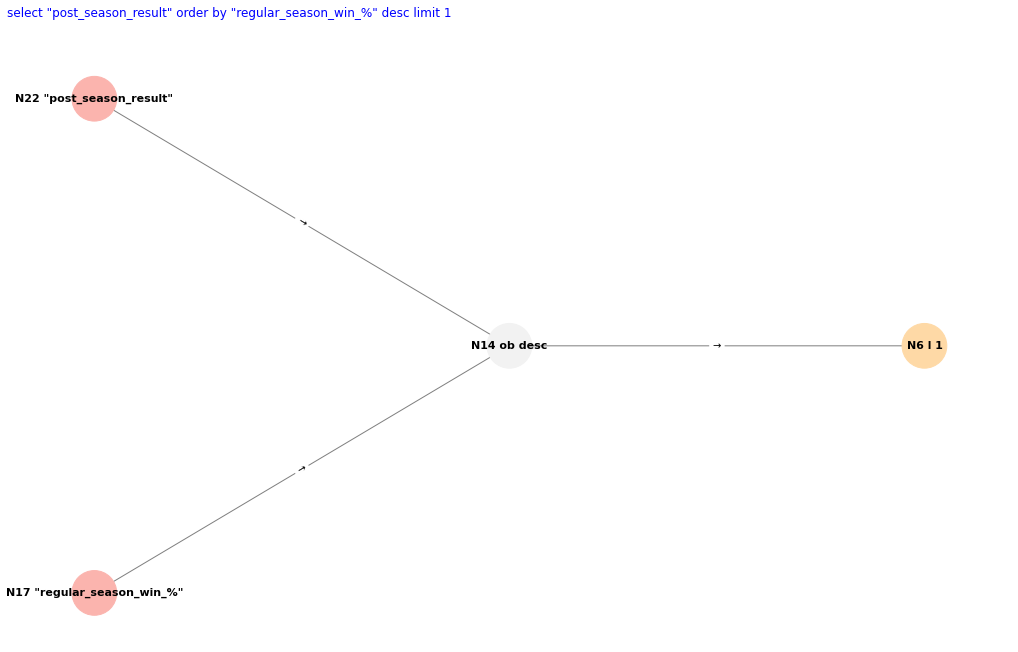

In [36]:
G0.create_cool_dag()

In [33]:
G0.edges

[('N11', 'N26'), ('N15', 'N26'), ('N12', 'N14'), ('N2', 'N12')]

In [87]:
G0.nodes


{'N22': <sql_graph_translate.nodes.Projection at 0x7fabd4491040>,
 'N14': <sql_graph_translate.nodes.OrderBy at 0x7fabd4491370>,
 'N6': <sql_graph_translate.nodes.Limit at 0x7fabd4491610>,
 'N17': <sql_graph_translate.nodes.Projection at 0x7fabd44910a0>}

In [35]:
for n in G0.nodes.values():
    #print(n.node_name,n.is_exec,n.parameter)
    print(n.result)

0                                                  none
1                                                  none
2        lost to seattle seahawks in afc wild card game
3     lost to pittsburgh steelers in afc divisional ...
4                                                  none
5             lost to new york giants in super bowl xxi
6        lost to washington redskins in super bowl xxii
7                                                  none
8        lost to san francisco 49ers in super bowl xxiv
9                                                  none
10       lost to buffalo bills in afc championship game
11                                                 none
12                                                 none
13    lost to san francisco 49ers in nfc divisional ...
14                                                 none
15                                                 none
16                                                 none
17                                              

In [336]:
from sql_graph_translate.utils import find_neighboor, find_last_edges, find_first_edges, remove_edges_first, compare_objects


ImportError: cannot import name 'directions' from 'sql_graph_translate.utils' (/home/jovyan/cloud/postgraduate/works/OmniGraph/TapexGraph/sql_graph_translate/utils.py)

In [36]:
G0.mapping_exec

In [31]:
G0.linearize_graph(Omega_includes[-1])

NameError: name 'Omega_includes' is not defined

In [16]:
from sql_graph_translate.utils import find_first_edges

In [17]:
def find_layer_neighboors(parent_node_names,edges):
    layer_neighboors = []
    for node in parent_node_names:
        layer_neighboors.extend(find_neighboors(node,edges))
    return set(layer_neighboors)

In [18]:
def find_neighboors(node_name, edges):
    return set(edge[1] for edge in list(filter(lambda t: t[0] == node_name, edges)))

In [19]:
def sort_graphe_execute_nodes(edges):
    sorted_nodes = []
    sorted_nodes.extend(find_first_edges(edges))
    layer_neighboors = sorted_nodes
    
    while len(layer_neighboors) > 0:
        print(layer_neighboors)
        layer_neighboors = find_layer_neighboors(layer_neighboors,edges)
        sorted_nodes.extend(layer_neighboors)
    return sorted_nodes

In [20]:
sort_graphe_execute_nodes(u)

NameError: name 'u' is not defined

In [134]:
def escape_special_characters(string):
    special_symbols = '.^$*+?{}[]\|()'
    return ''.join([f'\\{w}' if w in special_symbols else w for w in string])

In [85]:
" sss kgjke? kgjke kgjkes sdfgkj/djjkjd sgfj /".replace('sdfgkj','"sdfgkj"')

' sss kgjke? kgjke kgjkes "sdfgkj"/djjkjd sgfj /'

In [125]:
#['"#"', '"air_date"', '"timeslot_(est)"', '"season"', '"rating"', '"share"', '"18-49_(rating/share)"', '"viewers_(m)"', '"weekly_rank_(#)"']

x = escape_special_characters("select share where 18-49 (rating/share) = '3.2/9'")

In [148]:
def translate_query_to_graph_form(query,answer=None,flatten_mode = 'preorder',
                                  Omega_include=["P","C","S","GB","H","OB","A","OP","L"],task='tapex'):
    
    pattern = ' col : '
    try:
        sql,_ = query.split(pattern)
    except Exception as e:
        print(e)
    sql  = sql.strip()
    df = deserializ_tapex_linear_table(" col : "+query.split(" col : ")[1])
    
    new_column_names = [f'"{"_".join(head.split(" "))}"' for head in df.columns]
    print(new_column_names)
    for head in sorted(set(df.columns),key=len, reverse=True):
        sql = sql.replace(head,f'{"_".join(head.split(" "))}')
    print(sql)
    for head in set(df.columns):  
        print(escape_special_characters("_".join(head.split(" "))))
        sql = re.sub(f' {escape_special_characters("_".join(head.split(" ")))} '
                     ,f' "{"_".join(head.split(" "))}" ',sql) 
        #sql = sql.replace(head,f'"{"_".join(head.split(" "))}"') 
        print(sql)
    df.columns = new_column_names
    df['agg'] = np.zeros(df.shape[0])
    edges = []
    condi_expressions = {}
    G0 = create_nodes(sql, df=df,condi_expressions=condi_expressions,edges=edges)
    if task == 'tapex':
        sort_nodes = sort_graphe_execute_nodes(edges)
        #result = to_value_list(G0.executed_last_node())
        sort_nodes = sort_graphe_execute_nodes(edges)
        transformed_query = ' NODE '+f' NODE '.join(sort_nodes)
        return transformed_query+serialize_table_to_tapex_format(df), answer

In [149]:
translate_query_to_graph_form(train_src[226])

['"team"', '"city"', '"venue"', '"capacity"', '"head_coach"', '"team_captain"', '"past_season"']
select capacity where team_captain = 'saeed khani'
team_captain
select capacity where "team_captain" = 'saeed khani'
past_season
select capacity where "team_captain" = 'saeed khani'
city
select capacity where "team_captain" = 'saeed khani'
team
select capacity where "team_captain" = 'saeed khani'
venue
select capacity where "team_captain" = 'saeed khani'
head_coach
select capacity where "team_captain" = 'saeed khani'
capacity
select "capacity" where "team_captain" = 'saeed khani'
[]
[(SELECT expressions: 
  (COLUMN this: 
    (IDENTIFIER this: capacity, quoted: True)), where: 
  (WHERE this: 
    (EQ this: 
      (COLUMN this: 
        (IDENTIFIER this: team_captain, quoted: True)), expression: 
      (LITERAL this: saeed khani, is_string: True))))]
sub-query SELECT "capacity" WHERE "team_captain" = 'saeed khani' type <class 'sqlglot.expressions.Select'>
edges,cond
[('N13|P|select|0|0|"capa

(' NODE N13|P|select|0|0|"capacity" NODE N20|P|where0|0|0|"team_captain" NODE N29|S|selectwherep0|0|0|wherep0 NODE N25|C|where|0|0|= \'saeed khani\' NODE N29|S|selectwherep0|0|0|wherep0 col : "team" | "city" | "venue" | "capacity" | "head_coach" | "team_captain" | "past_season" | agg row 1 : aboomoslem | mashhad | samen | 35000 | ali hanteh | saeed khani | 4th | 0.0 row 2 : bargh shiraz | shiraz | hafezieh | 20000 | rasoul korbekandi | sattar zare | 7th | 0.0 row 3 : damash gilan | rasht | sardar jangal | 15000 | stanko poklepovic | mohammad reza mahdavi | 15th | 0.0 row 4 : est. ahvaz | ahvaz | takhti ahvaz | 30000 | khodadad azizi | afshin komaei | 8th | 0.0 row 5 : esteghlal | tehran | azadi | 90000 | amir ghalenoei | farhad majidi | 13th | 0.0 row 6 : foolad | ahvaz | takhti ahvaz | 15000 | majid jalali | ali badavi | qualifier | 0.0 row 7 : malavan | anzali | takhti anzali | 8000 | mohammad ahmadzadeh | masoud gholamalizad | 16th | 0.0 row 8 : mes kerman | kerman | shahid bahonar 

In [42]:
train_src[10]

"select when? where who? = 'leonardo da vinci' col : subject | robot's name | who? | when? | where? | occupation row 1 : solar system | cosmo-bot | copernicus | 1531 | poland | cosmonaut row 2 : olympics | rhonda robot | greeks | 776 b.c | greece | beauty queen row 3 : basketball | danny defrost-bot | james naismith | 1891 | united states | snowman row 4 : nursing | dr. bug-bot | florence nightengale | 1860 | england | doctor row 5 : scuba gear | flip the high-diving robot | jacques cousteau | 1946 | france | diver row 6 : helicopter | amelia air-bot | leonardo da vinci | 1483 | italy | pilot row 7 : corn flakes | chef boy-robot | william kellogg | 1894 | battle creek, michigan | cook row 8 : radium | miss battery-bot | marie curie | 1898 | france | battery lady row 9 : chewing gum | bubble-bot | mayans | 400 | mexico | bubble man row 10 : painting | pierro-bot | stone-age humans | 35,000 b.c | europe | clown/artist row 11 : phonograph | slide the heavy-metal robot | thomas edison | 18

In [91]:
train_tgt[28555]

'wilson & young'

In [96]:
_,result0=translate_query_to_graph_form(train_src[28555])

select owner where horse = 'bootmaker'
[]
[(SELECT expressions: 
  (COLUMN this: 
    (IDENTIFIER this: owner, quoted: False)), where: 
  (WHERE this: 
    (EQ this: 
      (COLUMN this: 
        (IDENTIFIER this: horse, quoted: False)), expression: 
      (LITERAL this: bootmaker, is_string: True))))]
sub-query SELECT owner WHERE horse = 'bootmaker' type <class 'sqlglot.expressions.Select'>
edges,cond
[('N16|P|select|0|0|owner', 'N22|S|selectwherep0|0|0|wherep0'), ('N5|P|where0|0|0|horse', "N23|C|where|0|0|= 'bootmaker'"), ("N23|C|where|0|0|= 'bootmaker'", 'N22|S|selectwherep0|0|0|wherep0')] {'S|selectwherep0|0|0|wherep0': 'wherep0', 'P|select|0|0|owner': (COLUMN this: 
  (IDENTIFIER this: owner, quoted: False)), 'P|where0|0|0|horse': (COLUMN this: 
  (IDENTIFIER this: horse, quoted: False)), "C|where|0|0|= 'bootmaker'": ((LITERAL this: bootmaker, is_string: True), <class 'sqlglot.expressions.EQ'>)}
cols
['owner', 'horse']
-----------
['N5|P|where0|0|0|horse', 'N16|P|select|0|0|owner'

In [35]:
a,b = translate_query_to_graph_form("select year opened where termini = 'west portal station' col : line | year opened | termini | termini row 1 : j church | 1917 | embarcadero station | balboa park station row 2 : k ingleside | 1918 | embarcadero station | balboa park station row 3 : l taraval | 1919 | embarcadero station | 46th avenue and wawona san francisco zoo row 4 : m ocean view | 1925 | embarcadero station | san jose and geneva balboa park station row 5 : n judah | 1928 | 4th and king station caltrain depot | judah and la playa ocean beach row 6 : t third street | 2007 | west portal station | sunnydale station row 7 : s castro shuttle (peak hours & game days) | none | embarcadero station 4th and king station (game days) | castro station west portal station (game days)")

[]
[(SELECT expressions: 
  (COLUMN this: 
    (IDENTIFIER this: year_opened, quoted: True)), where: 
  (WHERE this: 
    (EQ this: 
      (COLUMN this: 
        (IDENTIFIER this: termini, quoted: True)), expression: 
      (LITERAL this: west portal station, is_string: True))))]
sub-query SELECT "year_opened" WHERE "termini" = 'west portal station' type <class 'sqlglot.expressions.Select'>
edges,cond
[('N5|P|select|0|0|"year_opened"', 'N25|S|selectwherep0|0|0|wherep0'), ('N2|P|where0|0|0|"termini"', "N4|C|where|0|0|= 'west portal station'"), ("N4|C|where|0|0|= 'west portal station'", 'N25|S|selectwherep0|0|0|wherep0')] {'S|selectwherep0|0|0|wherep0': 'wherep0', 'P|select|0|0|"year_opened"': (COLUMN this: 
  (IDENTIFIER this: year_opened, quoted: True)), 'P|where0|0|0|"termini"': (COLUMN this: 
  (IDENTIFIER this: termini, quoted: True)), "C|where|0|0|= 'west portal station'": ((LITERAL this: west portal station, is_string: True), <class 'sqlglot.expressions.EQ'>)}
cols
['"year_opened"

In [28]:
!pip freeze

absl-py @ file:///home/conda/feedstock_root/build_artifacts/absl-py_1695154477682/work
accelerate==1.0.1
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1701099495371/work
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1616532146974/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
astunparse @ file:///home/conda/feedstock_root/build_artifacts/astunparse_1610696312422/work
async-generator==1.10
async-timeout @ file:///home/conda/feedstock_root/build_artifacts/async-timeout_1691763562544/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backca

In [36]:
a

' NODE N2|P|where0|0|0|"termini" NODE N5|P|select|0|0|"year_opened" NODE N4|C|where|0|0|= \'west portal station\' NODE N25|S|selectwherep0|0|0|wherep0 NODE N25|S|selectwherep0|0|0|wherep0 col : "line" | "year_opened" | "termini" | "termini" | agg row 1 : j church | 1917 | embarcadero station | balboa park station | 0.0 row 2 : k ingleside | 1918 | embarcadero station | balboa park station | 0.0 row 3 : l taraval | 1919 | embarcadero station | 46th avenue and wawona san francisco zoo | 0.0 row 4 : m ocean view | 1925 | embarcadero station | san jose and geneva balboa park station | 0.0 row 5 : n judah | 1928 | 4th and king station caltrain depot | judah and la playa ocean beach | 0.0 row 6 : t third street | 2007 | west portal station | sunnydale station | 0.0 row 7 : s castro shuttle (peak hours & game days) | none | embarcadero station 4th and king station (game days) | castro station west portal station (game days) | 0.0'

In [37]:
b

In [29]:
!pip install pandas==1.5.2


  Using cached pandas-1.5.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4


In [16]:
import pandas as pd

In [47]:
df = pd.Series({"a":[1,2,3]})

In [46]:
type(df.dtypes[0]).type(15)

15

In [52]:
df.dtypes.type(15)

15

In [53]:
df = pd.DataFrame({"a":[1,2,3]})

In [24]:
df.columns[0]

'team'

In [26]:
df[df.columns[0]][1].dtypes

AttributeError: 'str' object has no attribute 'dtypes'

In [50]:
    special_symbols = '.^$*+?{}[]\|()'


In [52]:
'.' in special_symbols

True